# Notebook to compare the unit activations of the last layer for all sentences in the dataset (original vs. perturbed conditions)

In [1]:
from os.path import abspath
import os
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import re

In [2]:
save = True

In [3]:
working_dir = "/om2/user/ckauf/.result_caching/neural_nlp.models.wrapper.core.ActivationsExtractorHelper._from_sentences_stored"

In [4]:
categories_control = ['original',
                      'length-control',
                      'constant-control']

categories_scrambled = ['original',
                        'Scr1',
                        'Scr3',
                        'Scr5',
                        'Scr7',
                        'lowPMI',
                        'lowPMI-random',
                        'backward',
                        'random-wl',
                        'random-wl-samepos']

categories_perturb_loss = ['original',
                           'nouns',
                           'nounsverbs',
                           'nounsverbsadj',
                           'contentwords',
                           'random-nouns',
                           'functionwords']

categories_perturb_meaning = ['sentenceshuffle_passage',
                              'sentenceshuffle_topic',
                              'sentenceshuffle_random']
                              #'sentenceshuffle_random-topic-criteria',
                              #'sentenceshuffle_random-topic-length-criteria']

categories_perturb = categories_perturb_loss + categories_perturb_meaning

categories = [categories_perturb, categories_scrambled, categories_control]
keys = ["perturb", "scrambled", "control"]

categories_dict = dict(zip(keys, categories))

In [5]:
def get_last_layer(model_identifier):
    """
    input: model_identifier of model of which we want to find the last layer
    output: last layer identifier
    """
    for ind,filename in enumerate(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            if any(substring in filename for substring in ["Original","nouns-random","length-control"]):
                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    result = pickle.load(f)
                result = result['data']
                layer_list = np.unique(result.layer)
                #order double-digit layers at end of list
                double_digits = []
                double_digits = [elm for elm in layer_list if 'encoder.h.' in elm and len(elm.split('.h.')[-1]) > 1]
                layers = [e for e in layer_list if e not in double_digits] + double_digits
                final_layer = layers[-1]
                return final_layer
                break
layers = get_last_layer("gpt2")

In [6]:
def get_passage_identifier(filename):
    """
    get passage identifier to be used as key for the dictionary.
    important step: fill the identifier with 0s for single-digit passage numbers
    """
    passage = filename.split("-")[-1].split(".")[0]
    number = passage.split("sentences")[-1]
    if len(number) == 1:
        passage_identifier = passage[:-1] + number.zfill(2)
    else:
        passage_identifier = passage
    return passage_identifier

In [7]:
def get_dictionary(model_identifier, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            if any(substring in filename for substring in ["Original","random-nouns","length-control"]):
                passage_identifier = get_passage_identifier(filename)
                
                condition = filename.split("Pereira2018-")[-1]
                condition = re.sub("lasttoken.*","", condition)
                condition = re.sub("avgtoken.*","", condition)
                condition = condition.rstrip("-")

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data']
                data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]

                if not passage_identifier in model_dictionary:
                    model_dictionary[passage_identifier] = {}
                model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary
dictionary = get_dictionary("gpt2", layer_identifier=None)

This is the layer I'm looking at:  encoder.h.11


In [8]:
def get_arrays(dictionary):
    sorted_dict = dict(sorted(dictionary.items()))
    original,nouns_random,length_control = ([] for i in range(3))
    #
    for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
        original.append(value['Original'].values)
        nouns_random.append(value['random-nouns'].values)
        length_control.append(value['length-control'].values)

    return original,nouns_random,length_control
original,nouns_random,length_control = get_arrays(dictionary)

In [9]:
def flatten_array(liste):
    liste_flatten = [item for sublist in liste for item in sublist]
    return liste_flatten

def prepare_dataframe(original,nouns_random,length_control,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                             'nouns_random':np.asarray(flatten_array(nouns_random)).flatten(),
                                'length_control':np.asarray(flatten_array(length_control)).flatten()
                               })
#     if not flatten:
#         # print(np.shape(np.asarray(flatten_array(random))))
#         df = {}
#         df = {'Original':flatten_array(original),
#                              'nouns':flatten_array(nouns),
#                               'nounsverbs':flatten_array(nounsverbs),
#                               'nounsverbsadj':flatten_array(nounsverbsadj),
#                               'contentwords':flatten_array(contentwords),
#                               'functionwords':flatten_array(functionwords),
#                               'passageshuffle':flatten_array(passageshuffle)}
    return df

In [10]:
df = prepare_dataframe(original,nouns_random,length_control,flatten=True)
df

,original,nouns_random,length_control
0,0.177159,-0.020141,-0.238690
1,-0.259414,-0.117412,-0.151004
2,-0.113374,0.036341,-0.249102
3,0.145448,-0.003541,-0.108892
4,-0.105586,0.119663,-0.165946
...,...,...,...
481531,0.239019,-0.166319,0.186209
481532,0.661861,-0.077194,0.236102
481533,0.637352,-0.167931,-0.150037
481534,-0.062437,0.121646,-0.116838


In [11]:
#determine x & ylim
print(np.min(list(df.min())))
print(np.max(list(df.max())))

-60.020362854003906
303.91754150390625


In [12]:
def limround(n):
    "helper function, rounds to multiples of 10, and extends a bit, used for x & ylims"
 
    if n < 0:
        b = (n // 10) * 10
     
    elif n >= 0:
        a = (n // 10) * 10
        b = a + 10
     
    return b

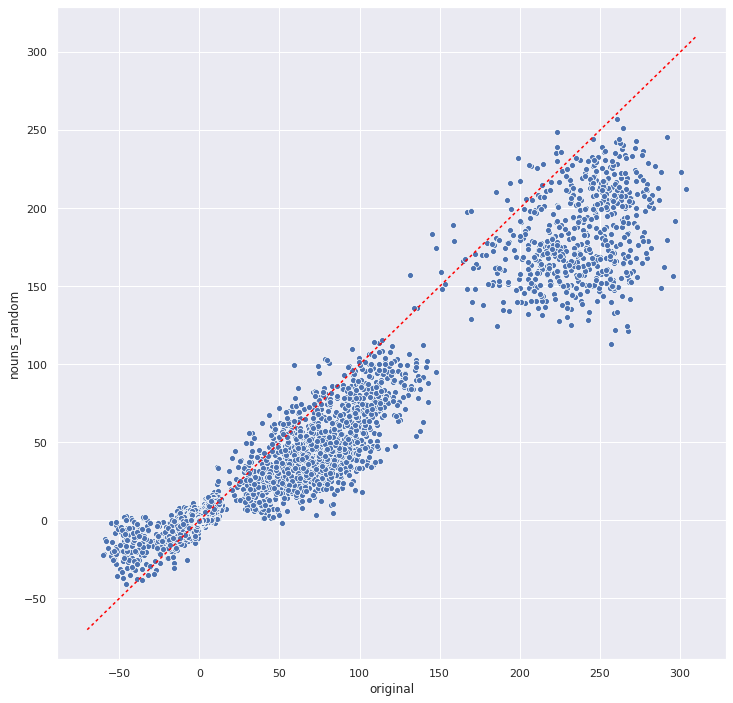

In [13]:
# import plotly.express as px
# fig = px.scatter(df, x="Original", y="nouns_random", width=800, height=800)
# fig.show()

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,12)})

def plot_activation_correlation(key1,key2,df):
    fig, ax = plt.subplots()
    ax = sns.scatterplot(data=df, x=key1, y=key2)
    
    lim_min = np.min(list(df.min()))
    lim_max = np.max(list(df.max()))
    lims = [lim_min, lim_max]
    lims = [limround(elm) for elm in lims]

    # Draw a line of x=y 
    ax = sns.lineplot(lims, lims, style=True, dashes=[(2,2)], color="red", legend=False)

    plt.show()

plot_activation_correlation("original","nouns_random",df)

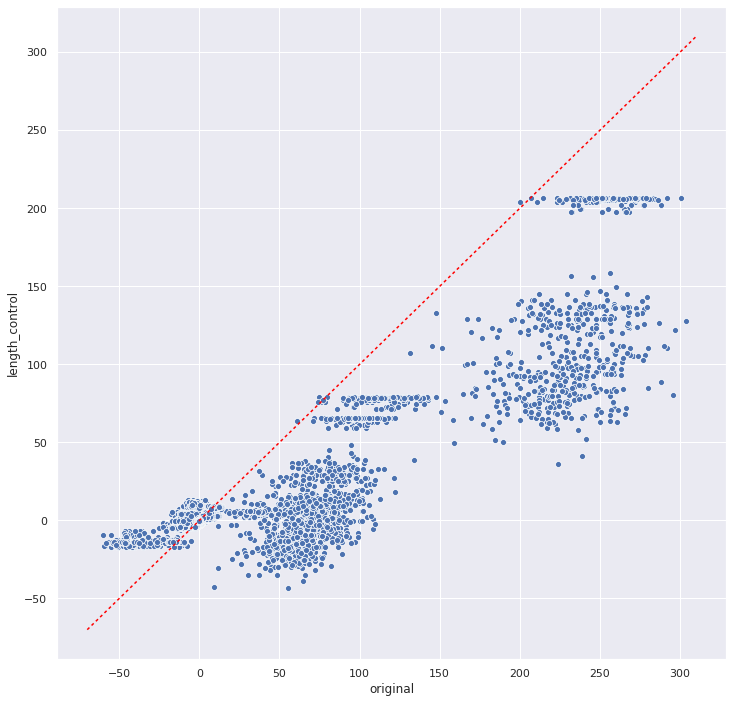

In [14]:
plot_activation_correlation("original","length_control",df)

# loop

In [15]:
def get_dictionary(model_identifier, scr_perturb=None, layer_identifier=None):
    """
    input: model identifier
    output: populated model dictionary with data of just the selected layer
    dictionary structure: passage_identifier --> condition identifier --> data
    """
    model_dictionary = model_identifier + "_dict"
    model_dictionary = {}
    
    #look at last layer by default
    if layer_identifier == None:
        layer_identifier = get_last_layer(model_identifier)
    else:
        layer_identifier = layer_identifier
    print("This is the layer I'm looking at: ", layer_identifier)
    
    for filename in tqdm(os.listdir(working_dir)):
        model_name = filename.split(",")[0]
        if "identifier=" + model_identifier == model_name:
            if (any(substring in filename for substring in categories_dict[scr_perturb])) or ("Original" in filename):
                passage_identifier = get_passage_identifier(filename)
                
                condition = filename.split("Pereira2018-")[-1]
                condition = re.sub("lasttoken.*","", condition)
                condition = re.sub("avgtoken.*","", condition)
                condition = condition.rstrip("-")

                file = os.path.join(working_dir,filename)
                with open(file, 'rb') as f:
                    out = pickle.load(f)
                result = out['data']
                data = result[{"neuroid": [layer == layer_identifier for layer in result["layer"].values]}]

                if not passage_identifier in model_dictionary:
                    model_dictionary[passage_identifier] = {}
                model_dictionary[passage_identifier][condition] = data
    
    return model_dictionary
dictionary = get_dictionary("gpt2", scr_perturb="control", layer_identifier=None)

This is the layer I'm looking at:  encoder.h.11


In [16]:
def get_arrays(dictionary,scr_perturb=None):
    #sort dictionary by passage identifier
    sorted_dict = dict(sorted(dictionary.items()))
    
    if scr_perturb == "scrambled":
        original, scrambled1, scrambled3, scrambled5, scrambled7, lowpmi, lowpmi_random, backward, random_wl, random_wl_samepos = ([] for i in range(len(categories_dict[scr_perturb])))
        for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
            #print(list(value.keys()))
            original.append(value['Original'].values)
            scrambled1.append(value['Scr1'].values)
            scrambled3.append(value['Scr3'].values)
            scrambled5.append(value['Scr5'].values)
            scrambled7.append(value['Scr7'].values)
            lowpmi.append(value['lowPMI'].values)
            lowpmi_random.append(value['lowPMI-random'].values)
            backward.append(value['backward'].values)
            random_wl.append(value['random-wl'].values)
            random_wl_samepos.append(value['random-wl-samepos'].values)
        
        return original,scrambled1,scrambled3,scrambled5,scrambled7,lowpmi,lowpmi_random,backward,random_wl,random_wl_samepos
            
    elif scr_perturb == "perturb":
        original,nouns,nounsverbs,nounsverbsadj,contentwords,random_nouns,functionwords,sent_passage,sent_topic,sent_random = ([] for i in range(len(categories_dict[scr_perturb])))
        #
        for key, value in sorted_dict.items(): #key is passage, value is dic from cond to xarray data
            #print(list(value.keys()))
            original.append(value['Original'].values)
            nouns.append(value['nouns'].values)
            nounsverbs.append(value['nounsverbs'].values)
            nounsverbsadj.append(value['nounsverbsadj'].values)
            contentwords.append(value['contentwords'].values)
            random_nouns.append(value['random-nouns'].values)
            functionwords.append(value['functionwords'].values)
            sent_passage.append(value['sentenceshuffle_passage'].values)
            sent_topic.append(value['sentenceshuffle_topic'].values)
            sent_random.append(value['sentenceshuffle_random'].values)

        return original,nouns,nounsverbs,nounsverbsadj,contentwords,random_nouns,functionwords,sent_passage,sent_topic,sent_random
    
    elif scr_perturb == "control":
        original,length_control, constant_control = ([] for i in range(len(categories_dict[scr_perturb])))
        for key, value in sorted_dict.items():
            #print(list(value.keys()))
            original.append(value['Original'].values)
            length_control.append(value['length-control'].values)
            constant_control.append(value['constant-control'].values)
        
        return original,length_control,constant_control

In [17]:
def prepare_dataframe_perturb(original,nouns,nounsverbs,nounsverbsadj,contentwords,random_nouns,functionwords,sent_passage,sent_topic,sent_random,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'nouns':np.asarray(flatten_array(nouns)).flatten(),
                               'nounsverbs':np.asarray(flatten_array(nounsverbs)).flatten(),
                               'nounsverbsadj':np.asarray(flatten_array(nounsverbsadj)).flatten(),
                               'contentwords':np.asarray(flatten_array(contentwords)).flatten(),
                               'random-nouns' :np.asarray(flatten_array(random_nouns)).flatten(),
                               'functionwords':np.asarray(flatten_array(functionwords)).flatten(),
                               'sent_passage': np.asarray(flatten_array(sent_passage)).flatten(),
                               'sent_topic': np.asarray(flatten_array(sent_topic)).flatten(),
                               'sent_random' : np.asarray(flatten_array(sent_random)).flatten()
                               })
    if not flatten:
        df = {}
        df = {'original':flatten_array(original),
             'nouns':flatten_array(nouns),
              'nounsverbs':flatten_array(nounsverbs),
              'nounsverbsadj':flatten_array(nounsverbsadj),
              'contentwords':flatten_array(contentwords),
              'random-nouns' : flatten_array(random_nouns),
              'functionwords':flatten_array(functionwords),
              'sent_passage':flatten_array(sent_passage),
              'sent_topic': flatten_array(sent_topic),
              'sent_random': flatten_array(sent_random)}
    return df

In [18]:
def prepare_dataframe_scrambled(original,scrambled1,scrambled3,scrambled5,scrambled7,lowpmi,lowpmi_random,backward,random_wl,random_wl_samepos,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'scrambled1':np.asarray(flatten_array(scrambled1)).flatten(),
                              'scrambled3' :np.asarray(flatten_array(scrambled3)).flatten(),
                              'scrambled5' :np.asarray(flatten_array(scrambled5)).flatten(),
                              'scrambled7':np.asarray(flatten_array(scrambled7)).flatten(),
                              'lowpmi':np.asarray(flatten_array(lowpmi)).flatten(),
                              'lowpmi_random':np.asarray(flatten_array(lowpmi_random)).flatten(),
                              'backward':np.asarray(flatten_array(backward)).flatten(),
                              'random-wl':np.asarray(flatten_array(random_wl)).flatten(),
                              'random-wl_samepos':np.asarray(flatten_array(random_wl_samepos)).flatten()
                               })
    if not flatten:
        # print(np.shape(np.asarray(flatten_array(random))))
        df = {}
        df = {'original':flatten_array(original),
             'scrambled1':flatten_array(scrambled1),
              'scrambled3' : flatten_array(scrambled3),
              'scrambled5' : flatten_array(scrambled5),
              'scrambled7':flatten_array(scrambled7),
              'lowpmi':flatten_array(lowpmi),
              'lowpmi_random':flatten_array(lowpmi_random),
              'backward':flatten_array(backward),
              'random-wl':flatten_array(random_wl),
              'random-wl_samepos':flatten_array(random_wl_samepos)
             }
    return df

In [19]:
def prepare_dataframe_control(original,length_control,constant_control,flatten=True):
    
    if flatten:
        df = pd.DataFrame(data={'original':np.asarray(flatten_array(original)).flatten(),
                               'length_control':np.asarray(flatten_array(length_control)).flatten(),
                                'constant_control':np.asarray(flatten_array(constant_control)).flatten()
                               })
    if not flatten:
        df = {}
        df = {'original':flatten_array(original),
             'length_control':flatten_array(length_control),
              'constant_control':flatten_array(constant_control)}
    return df

In [20]:
def main_df_for_plotting(model_identifier, scr_perturb=None, layer_identifier=None, flatten=True):
    dictionary = get_dictionary("gpt2", scr_perturb=scr_perturb, layer_identifier=None)
    if scr_perturb == "perturb":
        df = prepare_dataframe_perturb(*get_arrays(dictionary,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    elif scr_perturb == "scrambled":
        df = prepare_dataframe_scrambled(*get_arrays(dictionary,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    elif scr_perturb == "control":
        df = prepare_dataframe_control(*get_arrays(dictionary,scr_perturb=scr_perturb), flatten=flatten) #*flattens the tuple
    return df

In [21]:
#function check
plot_df = main_df_for_plotting("gpt2", scr_perturb = "control")
plot_df

This is the layer I'm looking at:  encoder.h.11


,original,length_control,constant_control
0,0.177159,-0.238690,0.016124
1,-0.259414,-0.151004,-0.233850
2,-0.113374,-0.249102,0.297444
3,0.145448,-0.108892,0.010785
4,-0.105586,-0.165946,-0.008794
...,...,...,...
481531,0.239019,0.186209,0.157540
481532,0.661861,0.236102,0.085209
481533,0.637352,-0.150037,0.140272
481534,-0.062437,-0.116838,-0.106851


`NOTE: 481536/768 = 627`

In [22]:
list(plot_df.columns)

['original', 'length_control', 'constant_control']

In [23]:
# import plotly.express as px
# fig = px.scatter(df, x="Original", y="nouns_random", width=800, height=800)
# fig.show()

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,12)})

def plot_activation_correlation(plot_df,key1,key2,lims, ax):
    ax = sns.scatterplot(data=plot_df, x=key1, y=key2)

    # Draw a line of x=y 
    ax = sns.lineplot(lims, lims, style=True, dashes=[(2,2)], color="red", legend=False)

    #plt.show()
    return ax

In [24]:
import math
from matplotlib.gridspec import GridSpec

def get_subplots_loop(plot_df, model_identifier=None, scr_perturb=None):
    column_list = list(plot_df.columns)
    nsubplots = len(column_list)
    nrows = math.ceil(nsubplots/2)
    
    fig2 = plt.figure(constrained_layout=True, figsize=(15, 6*nrows))
    fig2.suptitle('unit activations for all sentences at last layer | {} | {}'.format(model_identifier, scr_perturb), fontsize=22, y=1.05)
    spec2 = GridSpec(ncols=2, nrows=nrows, figure=fig2)
    f2_ax = []
    
    lim_min = np.min(list(plot_df.min()))
    lim_max = np.max(list(plot_df.max()))
    lims = [lim_min, lim_max]
    lims = [limround(elm) for elm in lims]
    
    counter = 0
    for i in range(nrows):
        for j in range(2):
            if counter + 1 > nsubplots:
                break
            else:
                print(column_list[counter])
                f2_ax.append(fig2.add_subplot(spec2[i, j]))
                f2_ax[-1] = plot_activation_correlation(plot_df,"original",column_list[counter],lims,f2_ax[-1])
                f2_ax[-1].set_title(f'{column_list[counter]}',fontsize=14, pad=15)
                counter += 1
    if save:
        fig2.savefig(abspath(f'../fig/check_embedding_comparison_{model_identifier}_{scr_perturb}.png'), bbox_inches='tight')

In [25]:
def loop_plot(model_identifier=None, scr_perturb=None):
    plot_df = main_df_for_plotting(model_identifier, scr_perturb = scr_perturb)
    get_subplots_loop(plot_df, model_identifier=model_identifier, scr_perturb=scr_perturb)

This is the layer I'm looking at:  encoder.h.11



original
length_control
constant_control


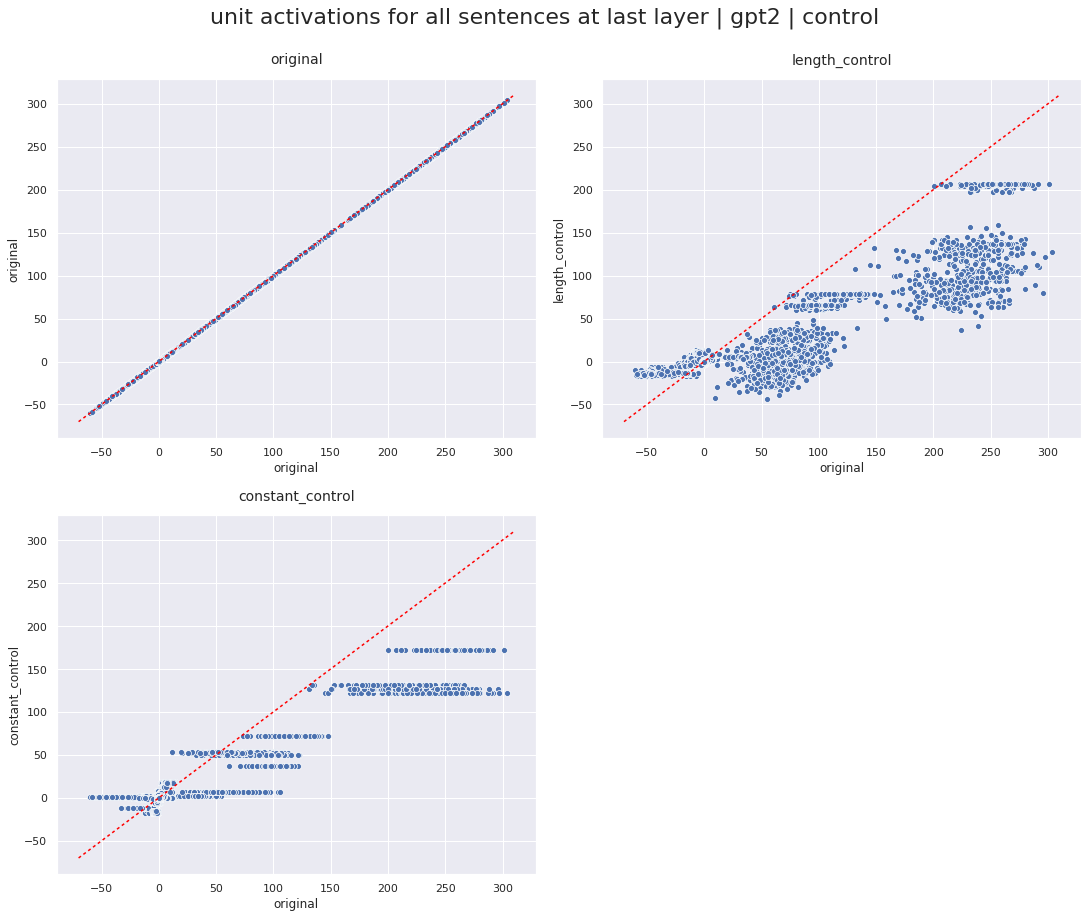

In [26]:
loop_plot("gpt2","control")

This is the layer I'm looking at:  encoder.h.11



original
length_control
constant_control


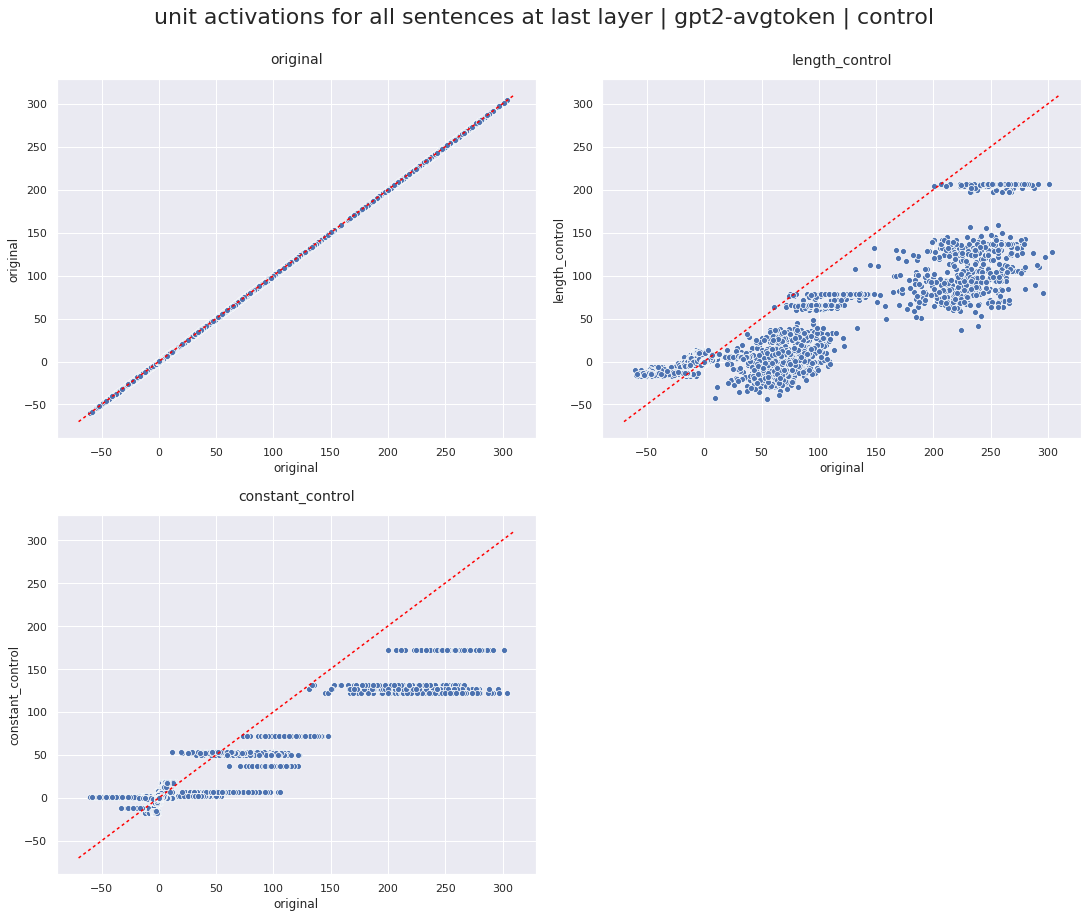

In [27]:
loop_plot("gpt2-avgtoken","control")

This is the layer I'm looking at:  encoder.h.11



original
scrambled1
scrambled3
scrambled5
scrambled7
lowpmi
lowpmi_random
backward
random-wl
random-wl_samepos


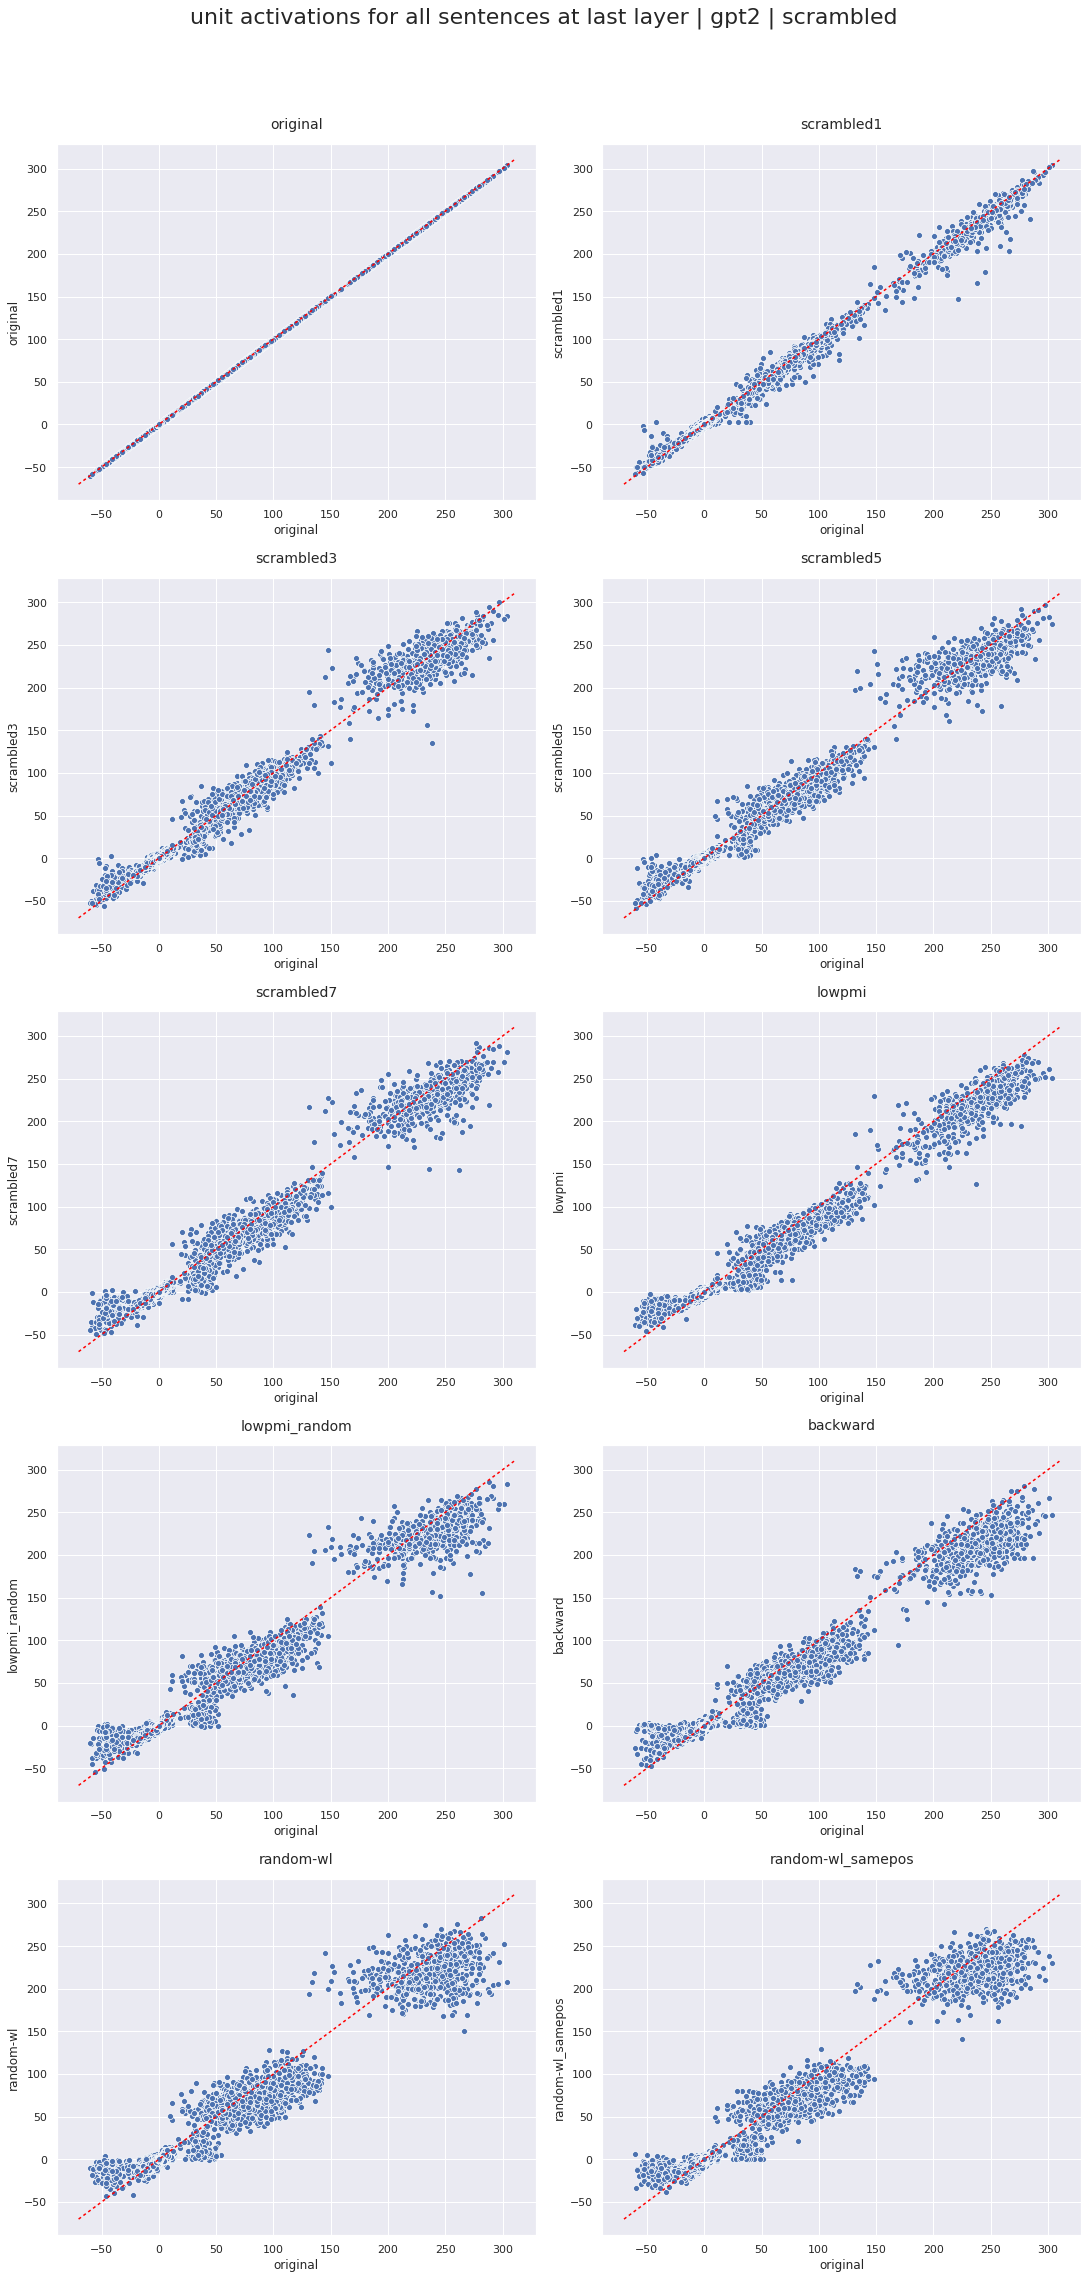

In [28]:
loop_plot("gpt2","scrambled")

This is the layer I'm looking at:  encoder.h.11



original
scrambled1
scrambled3
scrambled5
scrambled7
lowpmi
lowpmi_random
backward
random-wl
random-wl_samepos


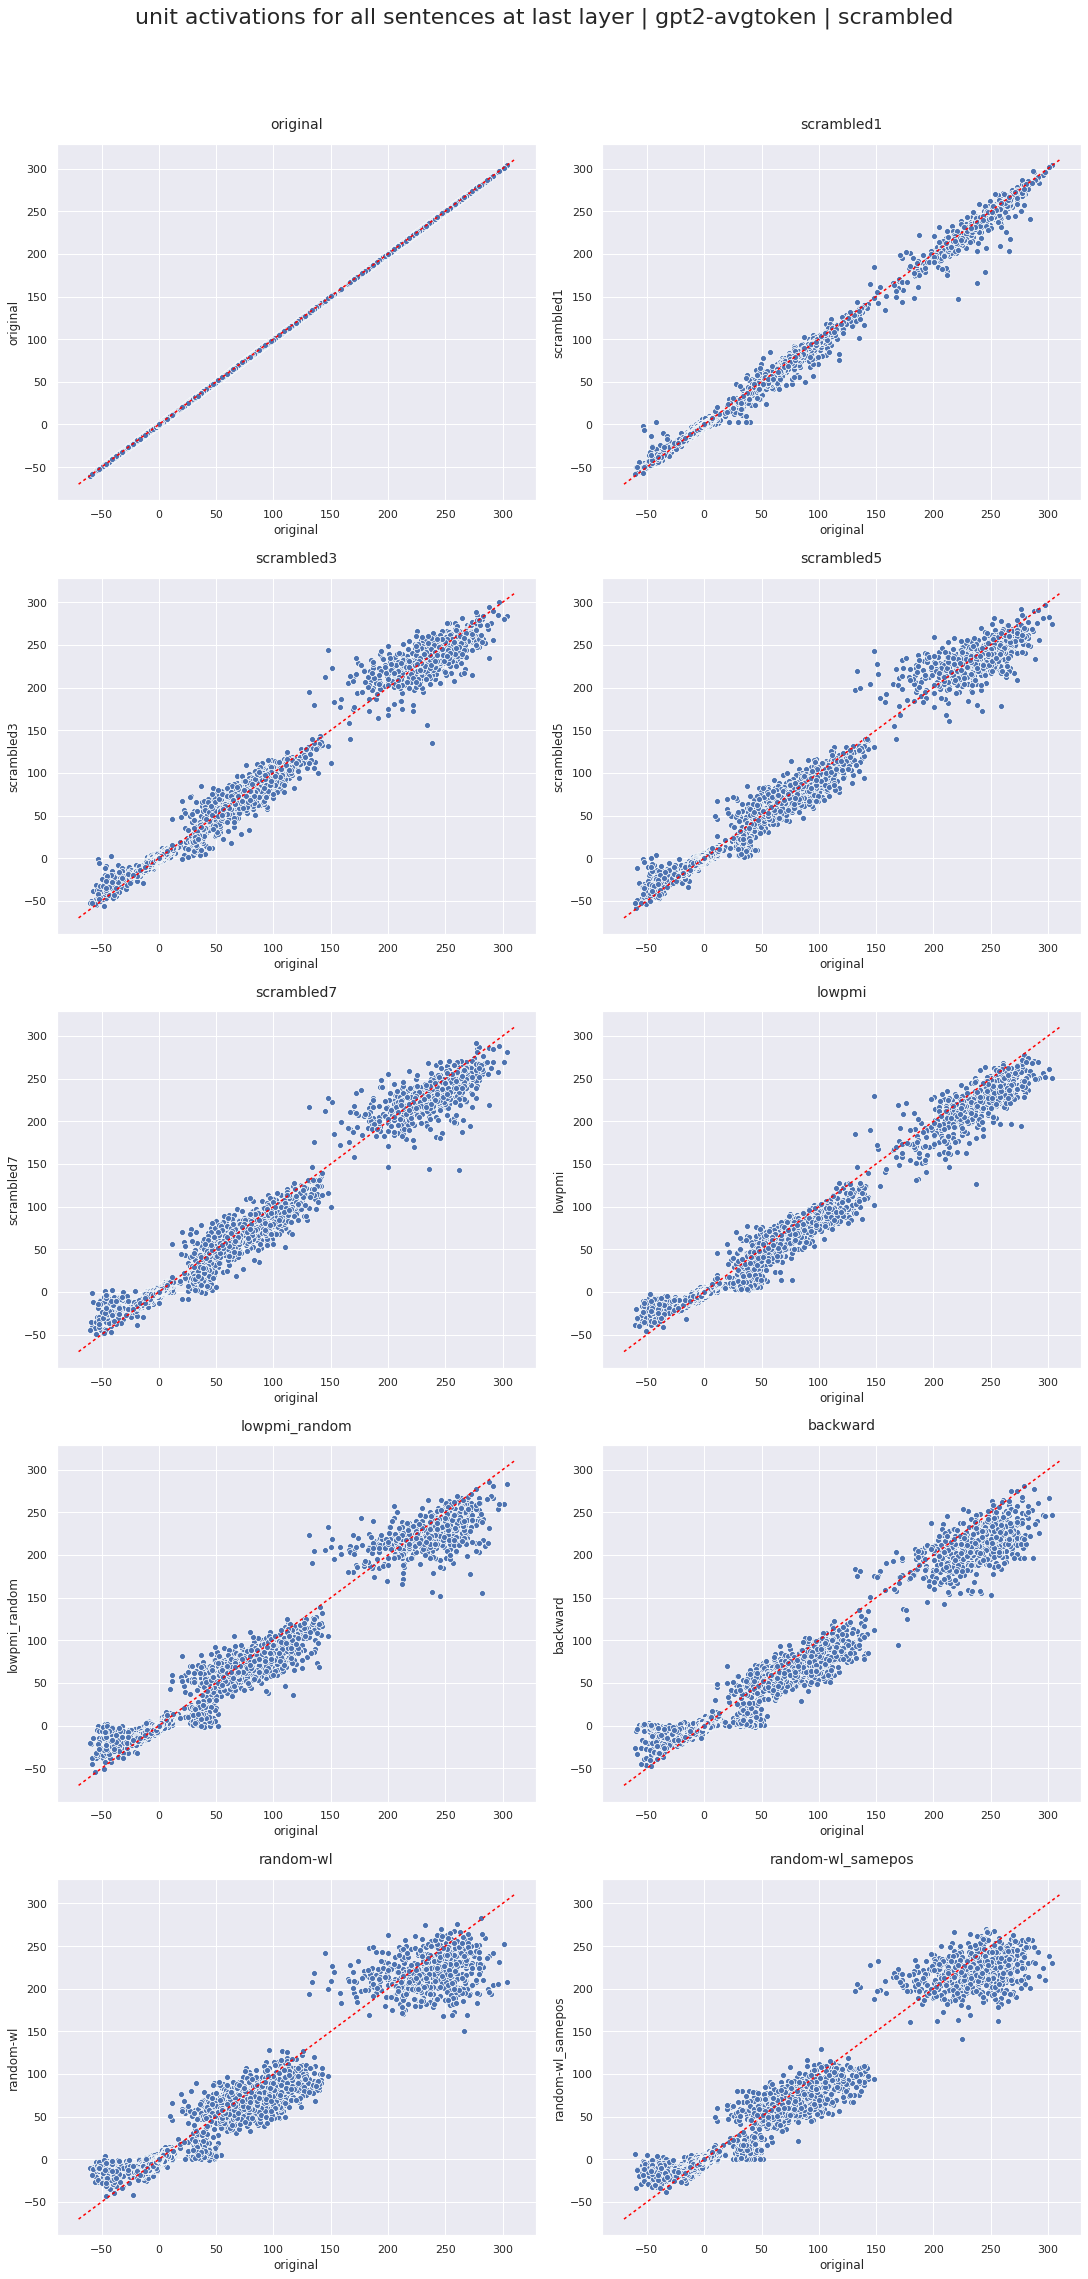

In [29]:
loop_plot("gpt2-avgtoken","scrambled")

This is the layer I'm looking at:  encoder.h.11



original
nouns
nounsverbs
nounsverbsadj
contentwords
random-nouns
functionwords
sent_passage
sent_topic
sent_random


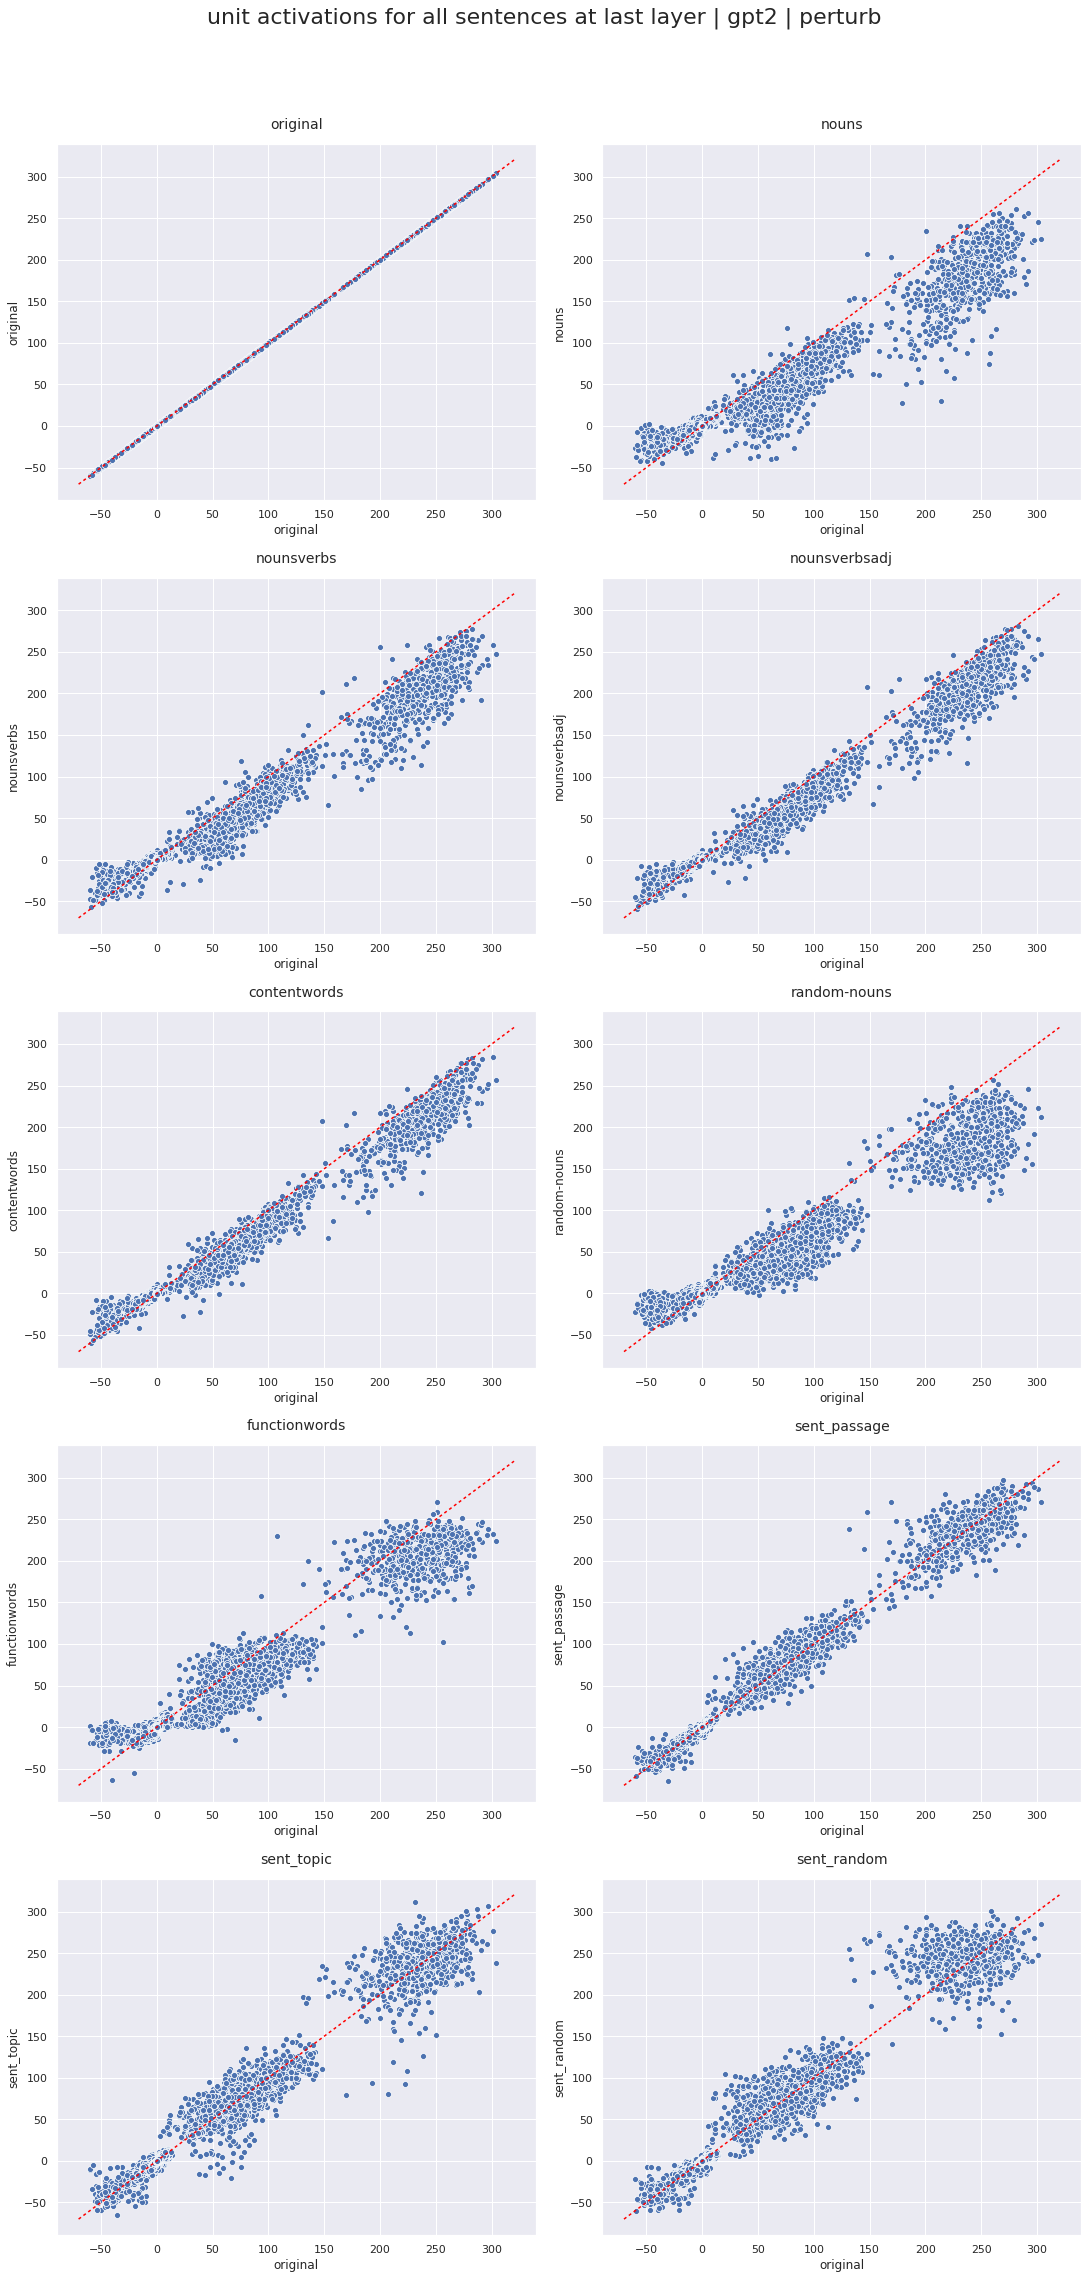

In [30]:
loop_plot("gpt2","perturb")

This is the layer I'm looking at:  encoder.h.11



original
nouns
nounsverbs
nounsverbsadj
contentwords
random-nouns
functionwords
sent_passage
sent_topic
sent_random


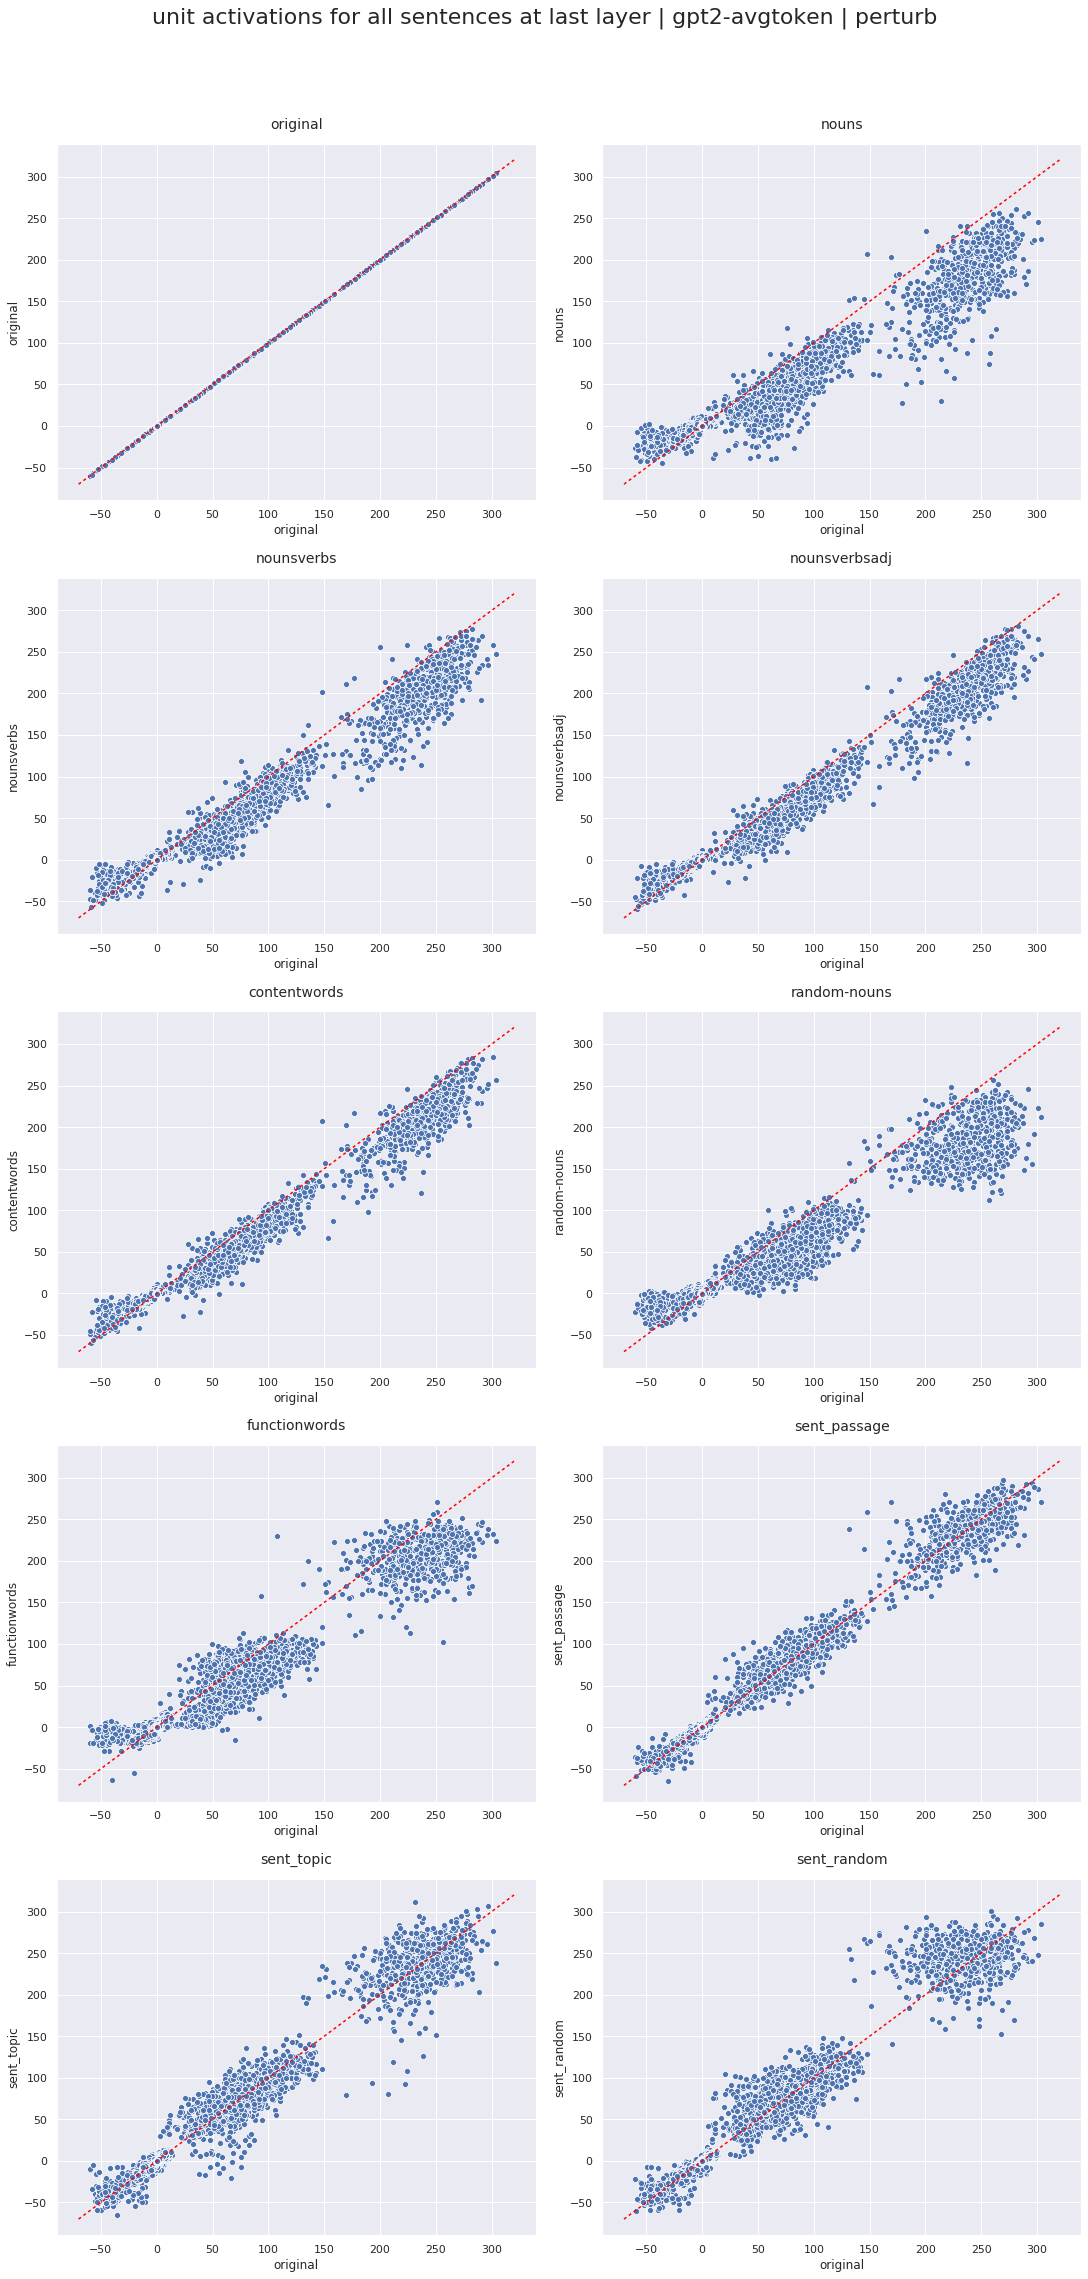

In [31]:
loop_plot("gpt2-avgtoken","perturb")